In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ee
import geopandas as gp
import rsfuncs as rs
import datetime

%load_ext autoreload
%autoreload 2

ee.Initialize()

In [2]:
shp = gp.read_file("../shape/cv.shp")
data = rs.load_data()


In [3]:
area = rs.gdf_to_ee_poly(shp)

In [4]:
years = range(2001, 2019)
months = range(1,13)
start = datetime.datetime(years[0], 1, 1)
end = datetime.datetime(years[-1]+1, 1, 1)
dt_idx = pd.date_range(start,end, freq='M')

In [5]:
eto_dat = rs.monthly_sum(data['gmet_eto'], years, months, area)

2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
wrapper complete


In [6]:
rsdata = pd.read_csv("../data/RS_DAT_FIN_monthly_2001_2018.csv")

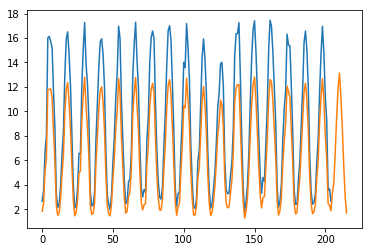

In [11]:
plt.plot(rsdata.gmet_eto)
plt.plot(eto_dat)

In [12]:
rsdata.rename(columns = {"gmet_eto":"gmet_etr"}, inplace = True)

In [13]:
rsdata['gmet_eto'] = np.array(eto_dat[:-11])

In [14]:
rsdata.to_csv("../data/RS_DAT_FIN_monthly_2001_2018.csv")

In [35]:
rsdata

,Unnamed: 0.1,fldas_aet,gldas_aet,modis_aet,tc_aet,nldas_etr,gldas_etr,gmet_etr,modis_pet,tc_pet,...,p_daymet,fldas_swe,gldas_swe,dmet_swet,gldas_sm,tc_sm,gldas_m,q_in,q_out,res_s
0,2001-01-31,4.076607,2.553393,3.803094,3.917899,8.197657,6.093209,8.655086,11.809674,4.076570,...,16.751653,1.881126,1.406164,166.339467,37.343913,13.683823,16.017710,0.763187,0.925951,23.926233
1,2001-02-28,5.418444,3.656616,3.491451,4.720649,8.973932,6.807488,9.629797,7.772501,4.970229,...,20.561220,3.863002,3.015322,235.424183,40.457645,18.947571,16.460951,0.915681,0.934155,25.577794
2,2001-03-31,9.236698,7.880229,6.028299,8.669927,18.762289,16.661255,18.202018,19.518689,12.074108,...,9.776323,4.190254,3.374577,316.701611,52.197920,18.812502,20.752214,1.097743,1.069754,28.062181
3,2001-04-30,9.832799,10.616467,4.924691,9.299260,23.643801,25.981846,21.208293,18.060522,15.294125,...,10.435274,1.700627,0.681465,321.098065,49.105741,16.988080,19.509192,1.103427,1.397268,29.296638
4,2001-05-31,11.893000,14.091119,6.292865,8.151635,44.019606,54.998029,42.298768,39.228458,28.715317,...,0.230130,0.224155,0.021983,292.185813,41.745014,11.386107,17.606792,1.396471,1.550421,29.414795
5,2001-06-30,8.458416,9.327713,3.081228,5.401945,48.631218,58.503256,42.296725,27.684521,31.812059,...,1.105542,0.000724,0.001287,202.193618,30.117654,7.225921,14.233435,1.533892,2.113784,25.820217
6,2001-07-31,6.186438,6.279170,5.406767,2.632845,51.620938,56.415857,42.503334,41.265602,32.086651,...,0.704927,0.000000,0.002751,138.582809,24.765123,5.376640,12.978348,1.666432,1.057053,22.333134
7,2001-08-31,3.431814,3.126869,3.488623,1.076177,49.729374,56.880687,42.039655,39.607967,30.663193,...,0.045638,0.000000,0.004121,84.938471,20.672723,4.359638,11.858216,1.262697,0.854919,19.985220
8,2001-09-30,2.318353,2.027855,3.475616,2.326682,38.030220,43.590865,32.058475,31.668153,22.539163,...,1.389698,0.000000,0.005193,47.921319,18.393092,3.690810,11.005479,0.874091,0.975769,18.910112
9,2001-10-31,1.609619,1.693475,2.185599,3.381225,27.776323,33.686437,24.342451,16.836352,14.770470,...,3.713344,0.003804,0.006526,31.283344,18.914635,3.247212,11.295301,0.688665,1.195543,17.818979


In [37]:
dt_idx[-1]

Timestamp('2018-12-31 00:00:00', freq='M')